# ESA EO $\phi$- week 2020

# Side Event 2: Euro Data Cube - Hands-on Tutorial and Training Session
---

In the previous part of the session you have already gained experience in navigating around the Euro Data Cube interface and using **GeoDB**. Now, we are going to show a use case example to demonstrate how you can combine some of what you have learnt with **Sentinel Hub Services**!

## Use Case Example: Deforestation in the Gran Chaco Region

In this Jupyter Notebook we are going to investigate deforestation events happening in the Gran Chaco region that spans across parts of eastern Bolivia, western Paraguay, northern Argentina and a small part of the Brazilian state of Mato Grosso. The region has one of the highest rates of deforestation in the world, mainly linked to the expansion of cattle farming. 

The following articles provide more context information on the subject: [Deforestation in Argentina’s Gran Chaco
](https://earthobservatory.nasa.gov/images/146731/deforestation-in-argentinas-gran-chaco), [Deforestation in Paraguay](https://earthobservatory.nasa.gov/images/92078/deforestation-in-paraguay), [WWF: Gran Chaco](https://www.worldwildlife.org/places/gran-chaco).



<img src="deforestation.jpg">
Deforested parcels in the Gran Chaco forest region (credit: John Burton, WLT).

<br>
Throughout the following examples we will see how to:

- request satellite imagery using the Python wrapper to the Sentinel Hub API service
- easily request metadata concerning images over a given area and time frame
- extract basic statistical information for a given area and time frame

First, we will access the [Global Forest Watch](http://www.globalforestwatch.org/about/) dataset (saved as a GeoDB in EDC) on deforestation in Gran Chaco. The original version can be downloaded [here](https://data.globalforestwatch.org/datasets/gran-chaco-deforestation). The dataset, that runs from 2011 to early 2018, represents deforested areas as polygons, derived manually using 30-meter resolution Landsat images for the 55 scenes that cover the Gran Chaco.

To check the temporal and spatial accuracy of the polygons, we will select a small test subset in Paraguay and compare the polygons representing deforestation events in January 2018 to higher resolution Sentinel-2 images. In this section we will see how to query data using Sentinel Hub's python package, and how to get metadata from the Catalog API in order to select the correct images without wasting ressources / time. 

We will then show you how to use the brand-new datafusion capabilities of Sentinel Hub services to mitigate the drawbacks of using optical sensors for deforestation detection.

Finally, we will investigate time series of Sentinel-2 images, deriving NDVI (Normalized Difference Vegetation Index) to see if the deforestation event can be automatically detected.

### Load necessary libraries

In [1]:
# EDC
from edc import setup_environment_variables
from xcube_geodb.core.geodb import GeoDBClient

# Sentinel Hub Py
from sentinelhub import (SHConfig, BBox, bbox_to_dimensions, CRS, SentinelHubRequest, DataSource, MimeType, FisRequest)
from sentinelhub.geometry import Geometry

# Utilities
from pathlib import Path
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session
from datetime import datetime as dt
import pandas as pd
import numpy as np

# Geographical libraries
import geopandas
from pyproj import Proj, transform
from shapely.geometry import shape, box
from shapely.ops import unary_union

# Plotting
import IPython
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib import colors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Rasterio
import rasterio
from rasterio.plot import show
import rasterio.features

### Setup environment variables

There are several options to setup your Sentinel Hub credentials, depending on how you want to access the services. In this workflow, as we will be working with the `sentinelhub-py` package to run requests in Python, we set up an `SHConfig` object that will take care of identification with the services for us. Therefore, we assign the identification parameters provided by EDC to the `SHConfig` object.

In [2]:
# Get identification parameters from EDC
setup_environment_variables()

# Setup SH services access
config = SHConfig()

config.sh_client_id = %env SH_CLIENT_ID
config.sh_client_secret = %env SH_CLIENT_SECRET
config.instance_id = %env SH_INSTANCE_ID

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:
* `GEODB_API_SERVER_PORT`, `GEODB_API_SERVER_URL`, `GEODB_AUTH_AUD`, `GEODB_AUTH_CLIENT_ID`, `GEODB_AUTH_CLIENT_SECRET`, `GEODB_AUTH_DOMAIN`
* `SH_CLIENT_ID`, `SH_CLIENT_NAME`, `SH_CLIENT_SECRET`, `SH_INSTANCE_ID`



Next, we set up access to the GeoDB, using `GeoDBClient` as shown in the previous section of this training session.

In [3]:
geodb = GeoDBClient()

## Request a truecolor image as overview of the selected area

Now that the credentials are set up, it is possible to request satellite images.

We will start by plotting an overview True Color RBG image from Sentinel-2 of the area the we will be working on.

The *Sentinel Hub Process API* will need the following information for a valid request:

+ An **AOI** (area of interest): that contains the location's coordinates (polygon or bounding box). The image size is pre-calculated according to the resolution desired.
+ **Evalscript** in which you specify the data products and their visualisation
+ **Request body** with parameters about the location and time

### Define coordinates for area of interest and create a bbox object

In [4]:
# Select the coordinates (lower-left, upper right) of our AOI
aoi_bbox = [-60.28157336, -21.27560428, -60.12293070, -21.18495133]

# Set AOI overview bbox
resolution = 10
aoi_overview = BBox(bbox=aoi_bbox, crs=CRS.WGS84)  # Make a BBox object of the list of coordinates
aoi_overview_size = bbox_to_dimensions(aoi_overview, resolution=resolution)  # Automatically calculate the output size in px

print(f"Output image size: {aoi_overview_size[0]} * {aoi_overview_size[1]} px")

Output image size: 1665 * 975 px


### Evalscript creation

An [Evalscript](https://docs.sentinel-hub.com/api/latest/evalscript/v3/) is a piece of Javascript code that allows you to define the input and output paramters of the data you would like to query, as well as specifying the processing to be applied to the satellite images.

For the evalscript you must specify at least the two following functions:

+ setup function: this sets up the input (i.e. which bands to call) and output settings (number of bands to return, format, etc...).
+ evaluatePixel function - this function is where you specify the processing (to derive new information from the images, or for visualisation) to be applied to the images.

In the following Evalscript, we want to return an RGB True Color image. In the `setup` function, we will specify that we want to use the Red (`B04`), Green (`B03`) and Blue (`B02`) bands of Sentinel-2. Since, we want a three-channel image (RGB), we specify that our output will have three bands. We use the convinient `AUTO` sample type for the returned data, as we are just going to visualise it. With `AUTO` values should range from 0-1, which will then automatically be stretched from the interval [0, 1] to [0, 255] and written into an UINT8 raster.

Because the image would be too dark if we return directly the band values scaled from 0 to 255, we apply a gain (multiplying the values by 3.5). This is just for visualisation purposes.

In [5]:
evalscript_true_color = """
//VERSION=3

// Set up the input and output settings

function setup() {
  return {
    input: ["B02", "B03", "B04"],  //define input bands
    output: { bands: 3, sampleType: SampleType.AUTO}  //define amount of channels in output image (RGB = 3), and UINT16 format
  };
}

// Map the input bands to the values in the output raster

function evaluatePixel(sample) {
  let gain = 3.5;
  return [gain * sample.B04, gain * sample.B03, gain * sample.B02];    //map bands 4, 3, 2 to RGB channels and multiply by 3.5 for enhanced truecolor visualisation
}
"""

### Request body creation

The run the Evalscript, we need to define the payload, or data parameters to send to Sentinel Hub Services. The Sentinel Hub python package simplifies the writing of the payload, by using the `SentinelHubRequest` class to pass the following input parameters:

1. the created evalscript
2. input data (data source and time interval)
3. define the output (name and format)
4. define bbox
5. size of requested image
6. identification with the SHConfig object


In [6]:
request = SentinelHubRequest(evalscript=evalscript_true_color,
                             input_data=[SentinelHubRequest.input_data(data_source=DataSource.SENTINEL2_L2A,
                                                                       time_interval=("2017-12-31",
                                                                                      "2017-12-31"))],
                            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
                            bbox=aoi_overview,  
                            size=aoi_overview_size,
                            config=config)

Now that the request is created, we just need to run it using the `get_data` method.

In [7]:
overview = request.get_data()

### Plot the requested image

By using `get_data` without any additional parameters saved the results to the `overview` variable. Let's plot it to look at the returned data.

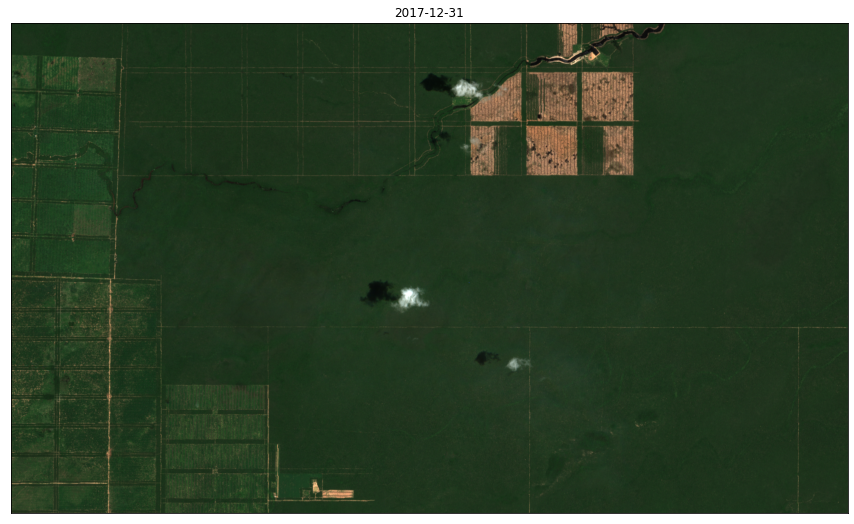

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
ax.imshow(overview[0])

# Plot configuration
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("2017-12-31")

plt.show()

### Quizz: can you figure out how to request a falsecolor infrared image?
Try to fill in the gaps in the evalscript below.

*Hint: To receive a falsecolor infrared image you need to map Sentinel-2 Band 8 (NIR) to the red channel, Band 4 (RED) to the green channel, and Band 3 (GREEN) to the blue channel*.

In [9]:
evalscript_false_color = """
//VERSION=3

function setup() {
  return {
    input: ["", "", ""],
    output: { bands: 3 }
  };
}

function evaluatePixel(sample) {
  let gain = 2.5;
  return [ , , ];
}
"""

Uncomment the following cell for the solution. Make sure to run the following cell twice, one time for fetching the solution and a second time for running the Evalscript.


In [38]:
# %load https://raw.githubusercontent.com/sentinel-hub/code-snippets/master/phiweek2020/Solution.py

Now that we have the Evalscript, let's run the request:

In [12]:
request = SentinelHubRequest(evalscript=evalscript_false_color,
                             input_data=[SentinelHubRequest.input_data(data_source=DataSource.SENTINEL2_L2A,
                                                                       time_interval=("2017-12-31",
                                                                                      "2017-12-31"))],
                            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
                            bbox=aoi_overview,  
                            size=aoi_overview_size,
                            config=config)

overview_fc = request.get_data()

### Plot the False Color image 

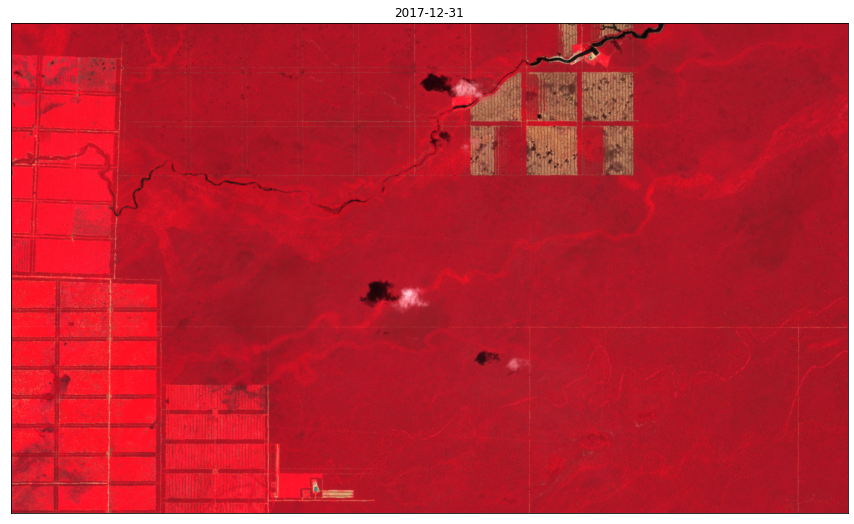

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
ax.imshow(overview_fc[0])

# Plot configuration
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("2017-12-31")

plt.show()

---

## Get the collection from GeoDB and data preparation
In the next step we retrieve the prepared gran_chaco collection from GeoDB.

As a reminder, you can explore the original dataset [here](https://data.globalforestwatch.org/datasets/gran-chaco-deforestation/data?geometry=-60.601%2C-20.023%2C-59.293%2C-19.797).

### Check available collections in GeoDB

Using the `geodb` client, let's look at what collections are available.

In [14]:
# Lets get already existing collections
geodb.get_my_collections()

,owner,database,table_name
0,anja,anja,demo_grant
1,anja,anja,E1
2,anja,anja,E10a1
3,anja,anja,E10a2
4,anja,anja,E11
5,anja,anja,E13c
6,anja,anja,E1a
7,anja,anja,E1_RACE_INDICATORS
8,anja,anja,E2
9,anja,anja,E4


### Query the collection by bbox to retrieve only the area we are interested in

We are interested in the `gran_chaco` GeoDB collection. However, we will not query it entirely in this exercise since we are only interested in a specific AOI that we defined further up. Therefore, not needing the whole dataset, we only retrieve the polygons that are contained in our area of interest by querying the dataset with our defined bbox.

In [15]:
gran_chaco = geodb.get_collection_by_bbox('gran_chaco', database="phi_week", bbox=aoi_bbox, bbox_crs=4326, comparison_mode="contains")

Let's preview the collection subset that we have just queried.

In [16]:
gran_chaco

,id,created_at,modified_at,geometry,objectid,field_id,pais,prov_dep,municipios,date,shape_leng,shape_area
0,9333,2020-09-25T07:57:39.568135+00:00,None,"POLYGON ((-60.26329 -21.27054, -60.26325 -21.2...",7784,9333,Paraguay,Boquerón,FILADELFIA,2011-12-31,3203.541559,5.661000e+05
1,9347,2020-09-25T07:57:39.568135+00:00,None,"POLYGON ((-60.26322 -21.23245, -60.26334 -21.2...",7798,9347,Paraguay,Boquerón,FILADELFIA,2011-12-31,23061.565888,4.140725e+06
2,40758,2020-09-25T07:57:44.48827+00:00,None,"POLYGON ((-60.26381 -21.25916, -60.26376 -21.2...",32303,40758,Paraguay,Boquerón,FILADELFIA,2014-10-31,247.465000,1.491147e+03
3,40763,2020-09-25T07:57:44.48827+00:00,None,"POLYGON ((-60.26370 -21.25423, -60.26392 -21.2...",32308,40763,Paraguay,Boquerón,FILADELFIA,2014-10-31,156.980834,8.272126e+02
4,40768,2020-09-25T07:57:44.48827+00:00,None,"POLYGON ((-60.26354 -21.24383, -60.26380 -21.2...",32313,40768,Paraguay,Boquerón,FILADELFIA,2014-10-31,244.941473,2.648666e+03
5,40770,2020-09-25T07:57:44.48827+00:00,None,"POLYGON ((-60.26355 -21.23751, -60.26350 -21.2...",32315,40770,Paraguay,Boquerón,FILADELFIA,2014-10-31,258.094701,2.089448e+03
6,58546,2020-09-25T07:57:45.943354+00:00,None,"POLYGON ((-60.19709 -21.20089, -60.19801 -21.2...",42365,58546,Paraguay,Boquerón,FILADELFIA,2015-10-31,35369.274281,5.651093e+06
7,58548,2020-09-25T07:57:45.943354+00:00,None,"POLYGON ((-60.17358 -21.19005, -60.17543 -21.1...",42365,58548,Paraguay,Boquerón,FILADELFIA,2015-10-31,35369.274281,5.651093e+06
8,66517,2020-09-25T07:57:47.16828+00:00,None,"POLYGON ((-60.23363 -21.25623, -60.24235 -21.2...",42700,66517,Paraguay,Boquerón,FILADELFIA,2016-06-30,63232.505444,1.189560e+07
9,66518,2020-09-25T07:57:47.16828+00:00,None,"POLYGON ((-60.23382 -21.26173, -60.25247 -21.2...",42700,66518,Paraguay,Boquerón,FILADELFIA,2016-06-30,63232.505444,1.189560e+07


### Data preparation

As we can see above, in the subset of the GeoDB that we queried, there are deforestation events detected in 2011, 2014, 2015, 2016, 2017 and 2018. Let's narrow down the dataset a little further and only select the polygons in 2018.

In the following cell, we convert the date strings to `datetime` objects to make the querying easier.

In [19]:
# Convert the dates to datetime objects and store in a new column
gran_chaco["datetime"] = pd.to_datetime(gran_chaco["date"])

In [20]:
# Select only polygons from 2018
gran_chaco_subset_2018 = gran_chaco[gran_chaco["datetime"].dt.year == 2018]

Now, we can preview the subset that we have selected based on the year 2018.

In [21]:
gran_chaco_subset_2018

,id,created_at,modified_at,geometry,objectid,field_id,pais,prov_dep,municipios,date,shape_leng,shape_area,datetime
25,88002,2020-09-25T07:57:49.678146+00:00,None,"POLYGON ((-60.19158 -21.20394, -60.18492 -21.2...",43800,88002,Paraguay,Boquerón,FILADELFIA,2018-01-31,74575.61818,1.049673e+07,2018-01-31
26,88006,2020-09-25T07:57:49.678146+00:00,None,"POLYGON ((-60.18432 -21.19408, -60.17995 -21.1...",43800,88006,Paraguay,Boquerón,FILADELFIA,2018-01-31,74575.61818,1.049673e+07,2018-01-31
27,88018,2020-09-25T07:57:49.678146+00:00,None,"POLYGON ((-60.17365 -21.20509, -60.17372 -21.2...",43800,88018,Paraguay,Boquerón,FILADELFIA,2018-01-31,74575.61818,1.049673e+07,2018-01-31
28,88019,2020-09-25T07:57:49.678146+00:00,None,"POLYGON ((-60.16963 -21.21093, -60.16956 -21.2...",43800,88019,Paraguay,Boquerón,FILADELFIA,2018-01-31,74575.61818,1.049673e+07,2018-01-31
29,88022,2020-09-25T07:57:49.678146+00:00,None,"POLYGON ((-60.19696 -21.20406, -60.19563 -21.2...",43800,88022,Paraguay,Boquerón,FILADELFIA,2018-01-31,74575.61818,1.049673e+07,2018-01-31
30,88024,2020-09-25T07:57:49.678146+00:00,None,"POLYGON ((-60.18506 -21.20018, -60.18504 -21.2...",43800,88024,Paraguay,Boquerón,FILADELFIA,2018-01-31,74575.61818,1.049673e+07,2018-01-31
31,88025,2020-09-25T07:57:49.678146+00:00,None,"POLYGON ((-60.19580 -21.21018, -60.19576 -21.2...",43800,88025,Paraguay,Boquerón,FILADELFIA,2018-01-31,74575.61818,1.049673e+07,2018-01-31
32,88028,2020-09-25T07:57:49.678146+00:00,None,"POLYGON ((-60.17258 -21.19252, -60.17215 -21.1...",43800,88028,Paraguay,Boquerón,FILADELFIA,2018-01-31,74575.61818,1.049673e+07,2018-01-31
33,88029,2020-09-25T07:57:49.678146+00:00,None,"POLYGON ((-60.16966 -21.19277, -60.16953 -21.1...",43800,88029,Paraguay,Boquerón,FILADELFIA,2018-01-31,74575.61818,1.049673e+07,2018-01-31
34,88030,2020-09-25T07:57:49.678146+00:00,None,"POLYGON ((-60.19818 -21.20492, -60.19834 -21.2...",43800,88030,Paraguay,Boquerón,FILADELFIA,2018-01-31,74575.61818,1.049673e+07,2018-01-31


In [22]:
# Plot all selected polygons
IPython.display.GeoJSON(gran_chaco_subset_2018.__geo_interface__)

<IPython.display.GeoJSON object>

Fun fact: thanks to Ipython, it is easy to zoom out to have an idea of the location of the polygons. Furthermore, you can click on an individual polygon to list the attributes of that specific shape in the dataframe.

---

## Query Catalog API for dates with  available Sentinel-2 data before and after the registered deforestation event

For our selected AOI, we will check if the registered deforestation date in the dataset that we are querying is correct. To do so, we will look at the closest cloud-free Sentinel images before and after the date assigned to the polygon (here, `2018-01-31`).

Rather than query all the Sentinel-2 images in a given time period around the date of interest, which would be a waste of ressources particularly in cloudy areas, we can use the Catalog API service to list metadata about the images that will guide our choice in the selection. The Catalog service allows us to return the dates of images intersecting the AOI, but other essential parameters, such as the scene's overall cloud cover.

### Create an OAuth2 session and create a token for it
In order to send a request to the Catalog API we need to create a token first. This acts like an ID we provide the API with to verify us as a registered user. This token is temporary (about 1h) for security reasons. If when running a Catalog request an authentification error is thrown, just execute the following cell again to obtain a new token.

In [23]:
# Create a session
client = BackendApplicationClient(client_id=config.sh_client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=config.sh_client_id, client_secret=config.sh_client_secret)

### Create the Catalog API request
We specify the service endpoint URL, set the Content-Type to 'application/json' because we only want to receive a list of dates with available Sentinel-2 data within the selected time period. We also set the `collection` that we want to query (here Sentinel-2 L1C), and the timerange we are interested in.

In [24]:
# Set the Catalog API url
catalog_url = "https://services.sentinel-hub.com/api/v1/catalog/"

# Set the header
headers = {
  'Content-Type': 'application/json'
}

# Set the Catalog request parameters
collections = "sentinel-2-l1c"
datetime= "2017-10-01T00:00:00Z/2018-02-15T23:59:59Z"  # We set a wide time range to get an idea of the available data

In [25]:
# Run the catalog request
response = oauth.request("GET", f"https://services.sentinel-hub.com/api/v1/catalog/collections/{collections}/items?bbox={aoi_bbox[0]},{aoi_bbox[1]},{aoi_bbox[2]},{aoi_bbox[3]}&datetime={datetime}&limit=20", headers=headers)
catalog_results = response.json()

In [26]:
# Fetch the dates and cloud cover values
available_data = []
for entry in catalog_results["features"]:
    available_data.append((entry["properties"]["datetime"], entry["properties"]["eo:cloud_cover"]))
    
print(available_data)

[('2018-02-14T14:10:42Z', 0.0), ('2018-02-09T14:10:39Z', 1.74), ('2018-02-04T14:10:42Z', 0.34), ('2018-01-30T14:10:39Z', 20.4), ('2018-01-20T14:14:24Z', 47.4), ('2018-01-15T14:10:50Z', 77.53), ('2018-01-10T14:10:37Z', 48.09), ('2017-12-31T14:13:44Z', 5.99), ('2017-12-26T14:10:40Z', 59.38), ('2017-12-21T14:10:33Z', 81.81), ('2017-12-11T14:10:34Z', 1.43), ('2017-12-06T14:10:41Z', 69.5), ('2017-12-01T14:12:55Z', 25.88), ('2017-11-21T14:14:18Z', 0.08), ('2017-11-16T14:10:43Z', 57.75), ('2017-11-11T14:10:32Z', 17.35), ('2017-10-27T14:11:07Z', 47.9), ('2017-10-22T14:10:32Z', 100.0), ('2017-10-07T14:10:44Z', 12.11), ('2017-10-02T14:11:57Z', 57.92)]


---

## Filter the available dates

We now have a list of images and their respective cloud cover available, we can filter out for the closest dates to the deforestation event marked in our database, taking in account the cloud cover. 

Let's select the images with less than 10% cloud cover over the entire scene.

In [27]:
# Set the date of interest. Since all the dates are the same in our subset, we take the first one.
deforestation_date = dt.strptime(gran_chaco_subset_2018.date.values[0], "%Y-%m-%d")

# Cloud cover percentage filter
cc = 10

# We want to select the dates that have less than the set % of cloud cover
available_datetimes = [dt.strptime(x[0], "%Y-%m-%dT%H:%M:%SZ") for x in available_data if x[1] <= cc]

# Find the index before and after our date of interest
past_dates = [date for date in available_datetimes if date < deforestation_date]
future_dates = [date for date in available_datetimes if date >= deforestation_date]

before_ind = available_datetimes.index(max(past_dates))
after_ind = available_datetimes.index(min(future_dates))

In [28]:
print(f"Closest date with less than {cc}% cloud cover. Before: {available_datetimes[before_ind]}; After: {available_datetimes[after_ind]}")

Closest date with less than 10% cloud cover. Before: 2017-12-31 14:13:44; After: 2018-02-04 14:10:42


---

## Query Sentinel-2 images

Now we have the dates that we are interested in, we will query the images using `sentinelhub-py`, as we did for the True Color and False Color RGB images.

First we set the bounding box to cover our selected field based on the geometry of the object in the database. We will set a buffer to make sure that we cover the entire set of polygons. Note that the buffer values are in degrees since the coordinates are in `WGS84`.

In [29]:
# Set AOI bounding box for our example field and image size according to desired resolution
resolution = 10
aoi = BBox(bbox=box(*gran_chaco_subset_2018.total_bounds).buffer(0.001).bounds, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi, resolution=resolution)

In our request, we will do things a little differently from the previous requests. Indeed, to be able to plot the extent of the field on our image, we need it to be georeferenced. Therefore, using the numpy array returned when calling the request is not sufficient. To get a georeferenced image, we will save the response as a `geotiff` locally, then open it with a geospatial library later (here we will use `rasterio`).

We will make two requests: one for the date before the event, that we selected earlier, and one after. Before each request, we make a directory to save the `geotiff`s and set the `save_data` parameter to `True` in the `get_data` method. Note, make sure that you delete any previous requests in the folders (if they exist).

In [32]:
# Make a directory to save the response
Path('./results/before').mkdir(parents=True, exist_ok=True)
  
request = SentinelHubRequest(evalscript=evalscript_true_color,
                             input_data=[SentinelHubRequest.input_data(data_source=DataSource.SENTINEL2_L2A,
                                                                       time_interval=(dt.strftime(available_datetimes[before_ind], "%Y-%m-%d"),
                                                                                      dt.strftime(available_datetimes[before_ind], "%Y-%m-%d")))],
                            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
                            bbox=aoi,  
                            size=aoi_size,
                            data_folder='./results/before/',
                            config=config)

true_color_before = request.get_data(save_data=True)

In [33]:
# Make a directory to save the response
Path('./results/after').mkdir(parents=True, exist_ok=True)
  
request = SentinelHubRequest(evalscript=evalscript_true_color,
                             input_data=[SentinelHubRequest.input_data(data_source=DataSource.SENTINEL2_L2A,
                                                                       time_interval=(dt.strftime(available_datetimes[after_ind], "%Y-%m-%d"),
                                                                                      dt.strftime(available_datetimes[after_ind], "%Y-%m-%d")))],
                            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
                            bbox=aoi,  
                            size=aoi_size,
                            data_folder='./results/after/',
                            config=config)

true_color_after = request.get_data(save_data=True)

Now that we have downloaded the data, let's fetch the path to the resulting `geotiff`s and open them with rasterio.

In [34]:
# Get folder name created
fld_a = [f for f in Path("./results/before/").iterdir() if f.is_dir()][0]
fld_b = [f for f in Path("./results/after/").iterdir() if f.is_dir()][0]

# Open raster with Rasterio
raster_before = rasterio.open(str(fld_a.joinpath("response.tiff")))
raster_after = rasterio.open(str(fld_b.joinpath("response.tiff")))

### Plot the raster images saved locally and show the outline of the selected field in the database

Here will plot the georeferenced rasterio rasters and add the field outlines over the images.

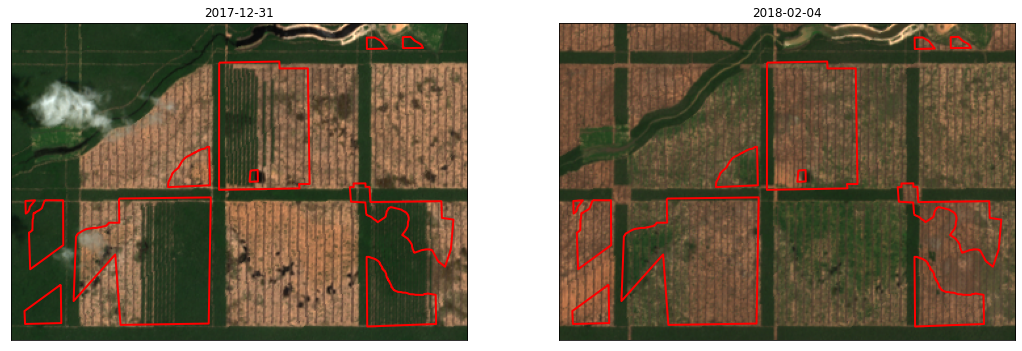

In [35]:
fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))

# Plot images before and after
show(raster_before, ax=ax)
show(raster_after, ax=ax1)

# Plot the field outline over the images
gran_chaco_subset_2018.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2)
gran_chaco_subset_2018.plot(ax=ax1, edgecolor="red", facecolor="none", linewidth=2)

# Plot configuration
for axs in [ax, ax1]:
    axs.set_xticks([])
    axs.set_yticks([])

ax.set_title(dt.strftime(available_datetimes[before_ind], "%Y-%m-%d"))
ax1.set_title(dt.strftime(available_datetimes[after_ind], "%Y-%m-%d"))

plt.show()

In the image above, we notice several points:

1. For some of the smaller polygons we can see that the deforestation happened between the 31<sup>st</sup> December 2017 and 4<sup>th</sup> February 2018. Due to cloud coverage, we cannot narrow down the date any more. But we will get back to this point later in the process.

2. The larger polygons that were identified as deforested in January 2018 in the dataset were already partly deforested in December 2017.

3. Certain areas delimited manually based on the Landsat images seems shifted compared to the Sentinel-2 images: i.e. the large polygon top centre. This shift may be due to the difference in resolution or slight geolocalisation differences between the sensors.  

### Compare with Landsat imagery

To see the field delination on a Landsat image, we can query a Landsat image as we did for Sentinel. 

## Quizz: what is the easiest way to write an Evalscript for Landsat True Color?

Based on Landsat [bands](https://docs.sentinel-hub.com/api/latest/data/landsat-8/) available, how would you return a True Color image using the Evalscript?



In [ ]:
evalscript_landsat_true_color = """"""

# Adjust the image size for the change in resolution
aoi_size_landsat = bbox_to_dimensions(aoi, resolution=30)

Uncomment the following cell for the solution. Make sure to run the following cell twice, one time for fetching the solution and a second time for running the Evalscript.

In [ ]:
# %load https://raw.githubusercontent.com/sentinel-hub/code-snippets/master/phiweek2020/Solution2.py

Bonus question: how would you improve the resolution of the True Color image?

In [ ]:
evalscript_landsat_true_color_improved = """"""

Uncomment the following cell for the solution. Make sure to run the following cell twice, one time for fetching the solution and a second time for running the Evalscript.


In [ ]:
# %load https://raw.githubusercontent.com/sentinel-hub/code-snippets/master/phiweek2020/Solution3.py

Run the query (using the evalscript of your choice) for two dates that were preselected.

In [ ]:
# Make a directory to save the request
Path('./results/landsat/before').mkdir(parents=True, exist_ok=True)
  
request = SentinelHubRequest(evalscript=evalscript_landsat_true_color,
                             input_data=[SentinelHubRequest.input_data(data_source=DataSource.LANDSAT8_L1C,
                                                                       time_interval=("2017-12-16",
                                                                                      "2017-12-16"))],
                            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
                            bbox=aoi,  
                            size=aoi_size_landsat,
                            data_folder='./results/landsat/before',
                            config=config)

true_color_landsat= request.get_data(save_data=True)

In [ ]:
# Make a directory to save the request
Path('./results/landsat/after').mkdir(parents=True, exist_ok=True)
  
request = SentinelHubRequest(evalscript=evalscript_landsat_true_color,
                             input_data=[SentinelHubRequest.input_data(data_source=DataSource.LANDSAT8_L1C,
                                                                       time_interval=("2018-01-17",
                                                                                      "2018-01-17"))],
                            responses=[SentinelHubRequest.output_response('default', MimeType.TIFF)],
                            bbox=aoi,  
                            size=aoi_size_landsat,
                            data_folder='./results/landsat/after',
                            config=config)

true_color_landsat= request.get_data(save_data=True)

As we did for Sentinel-2, fetch the latest folder and open the image with Rasterio.

In [ ]:
# Get folder name created
fld_lb = [f for f in Path("./results/landsat/before").iterdir() if f.is_dir()][0]
fld_la = [f for f in Path("./results/landsat/after").iterdir() if f.is_dir()][0]

# Open raster with Rasterio
raster_landsat_before = rasterio.open(str(fld_lb.joinpath("response.tiff")))
raster_landsat_after = rasterio.open(str(fld_la.joinpath("response.tiff")))

### Plot the Landsat scene saved locally and show the outline of the selected field in the database

In [ ]:
fig, (ax, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))

# Plot images before and after
show(raster_landsat_before, ax=ax)
show(raster_landsat_after, ax=ax1)

# Plot the field outline over the images
gran_chaco_subset_2018.plot(ax=ax, edgecolor="red", facecolor="none", linewidth=2)
gran_chaco_subset_2018.plot(ax=ax1, edgecolor="red", facecolor="none", linewidth=2)

# Plot configuration
for axs in [ax, ax1]:
    axs.set_xticks([])
    axs.set_yticks([])

ax.set_title("2017-12-16")
ax1.set_title("2018-01-17")

plt.show()

Looking at the Landsat images in December 2017 and Janauary 2018, provides more information on how the polygons were delineated. Indeed, owing to the revisit time of Landsat (14 days) and cloud cover, some of the deforestation events that happened end of December 2017 (as we saw in the Sentinel-2 images) were missed. The Landsat acquisition on 17<sup>th</sup> January 2018 provides more insight in the timing of the deforestation. Nevertheless, two of the polygon were already partly deforested in December 2017, which could mean that the dataset contains operator errors. The images also show that the 31<sup>st</sup> January 2018 indicated in the dataset is an arbotrary date representing the entire month of January.

---

## "Filling in the Gaps" or how to use data fusion to mitigate gaps in optical imagery time series

In the previous section, we were able to fetch Sentinel-2 images to observe deforestation events. However, in January all the scenes acquired were completely cloud covered. As a recap, let's just look at cloud cover for that time of year using the previous catalog request.


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

# Plot the cloud cover for available dates
ax.plot([dt.strptime(x[0], "%Y-%m-%dT%H:%M:%SZ") for x in available_data], [x[1] for x in available_data], marker='o',
        markersize=12, linestyle="none", color="black")

# Highligh January
ax.fill_between((dt.strptime("2018-01-01", "%Y-%m-%d"), dt.strptime("2018-01-31", "%Y-%m-%d")), (0,0), (100,100), color="red", alpha=0.3)

# Plot 5% level
ax.plot([dt.strptime(x[0], "%Y-%m-%dT%H:%M:%SZ") for x in available_data], [10 for x in available_data], linestyle="--", linewidth=2, color="black")

# Plot configuration
ax.set_ylim(0,100)
ax.set_ylabel("Cloud cover percentage")
ax.set_xlabel("Date")

plt.show()

We also know that the deforestation happened before the 17<sup>th</sup> January 2018, when looking at the Landsat image. But is there any way of checking with an other satellite platform that isn't affected by clouds?

By combining optical imagery with SAR (Synthetic Aperture Radar), the shortcomings of cloud cover can be (partly) mitigated. In this example, we will use Sentinel-1 images. Although the revisit frequency of Sentinel-1 is similar to Sentinel-2 (approximately 6 days at the equator), the additional data may be used to increase the temporal resolution of time-series regardless of local atmospheric conditions.



### Datafusion

We recently wrote a [blog post](https://medium.com/sentinel-hub/data-fusion-combine-satellite-datasets-to-unlock-new-possibilities-26356c481169) about the new datafusion capabilities of Sentinel Hub services. Here, we will combine Sentinel-2 and Sentinel-1 images to detect deforestation event that happened in January.

First we will use the Catalog API service again to obtain the list of available Sentinel-1 acquisitions in January 2018.

In [ ]:
# Set the Catalog API url
catalog_url = "https://services.sentinel-hub.com/api/v1/catalog/"

# Set the header
headers = {
  'Content-Type': 'application/json'
}

# Set the Catalog request parameters
collections = "sentinel-1-grd"  # This time, we use the Sentinel 1 collection
datetime= "2018-01-01T00:00:00Z/2018-01-31T23:59:59Z"  # Time range over January 2018

# Run the catalog request
response = oauth.request("GET", f"https://services.sentinel-hub.com/api/v1/catalog/collections/{collections}/items?bbox={aoi_bbox[0]},{aoi_bbox[1]},{aoi_bbox[2]},{aoi_bbox[3]}&datetime={datetime}&limit=20", headers=headers)
catalog_results = response.json()

# Fetch the dates and write to a list
s1_dates = []

for entry in catalog_results["features"]:
    s1_dates.append(entry["properties"]["datetime"])
    
print(s1_dates)

With the Catalog service API, we see that there are 6 images available for Janauary 2018.

### Evalscript

In the following Evalscript we will perform the following steps for each pixel in the image:

+ check if the pixel's NDVI (see below) value has dropped between December and February. If it hasn't, we will assume there was no deforestation in January and return the Sentinel-2 True Color RGB.
+ if the NDVI has dropped from above 0.4 to below 0.4 (an empirical threshold that we set), we then look at the backscatter between different Sentinel-1 dates.
+ if the drop in backscatter from a date to another is larger than a given value (once again empirically determined), then we return a color according to the date.

To perform the operations in the list above, we need:

- the closest cloud-free Sentinel-2 image before January
- the closest cloud-free Sentinel-2 image after January
- all Sentinel-1 images in January

<br>**NDVI (Normalized difference vegetation index)**

_The well known and widely used NDVI is a simple, but effective index for quantifying green vegetation. It normalizes green leaf scattering in Near Infra-red wavelengths with chlorophyll absorption in red wavelengths._

_The value range of the NDVI is -1 to 1. Negative values of NDVI (values approaching -1) correspond to water. Values close to zero (-0.1 to 0.1) generally correspond to barren areas of rock, sand, or snow. Low, positive values represent shrub and grassland (approximately 0.2 to 0.4), while high values indicate temperate and tropical rainforests (values approaching 1)._<br>

Here we color coded the changes as follows:

2018-01-01 -> 2018-01-02 = ORANGE


2018-01-02 -> 2018-01-13 = WHITE


2018-01-13 -> 2018-01-14 = BLUE


2018-01-14 -> 2018-01-25 = GREEN


2018-01-25 -> 2018-01-26 = RED

In [ ]:
evalscript_data_fusion = """
//VERSION=3

function setup (){
  return {
    input: [
      {datasource: "s1", bands:["VH"]},
      {datasource: "s2_before", bands:["B02", "B03", "B04", "B08"]},
      {datasource: "s2_after", bands:["B02", "B03", "B04", "B08"]}],
    output: [
      {id: "default", bands: 3}
    ],
    mosaicking: "ORBIT"
  };
}
  
// visualizes decibels from -20 to 0
function toDb(linear) {
  // the following commented out lines are simplified below
  // var log = 10 * Math.log(linear) / Math.LN10
  // var val = Math.max(0, (log + 20) / 20)
  return Math.max(0, Math.log(linear) * 0.21714724095 + 1)
}
  
function evaluatePixel(samples, scenes) {

  // Get samples from different specified datasources
  var s1 = samples.s1;
  var s2before = samples.s2_before[0];
  var s2after = samples.s2_after[0];
 
  // Calculate NDVI before January and after
  let ndvi_before = index(s2before.B08, s2before.B04);
  let ndvi_after = index(s2after.B08, s2after.B04);
  

  // If NDVI drop between dates is more than 0.4, query S1 data,
  // otherwise return True Color
  if (ndvi_before > 0.4 && ndvi_after < 0.4){
  
     let threshold_bc = 0.005;
      
     // Return different dates by color
     if (toDb(s1[1].VH) - toDb(s1[0].VH) > threshold_bc){
        return [255/255, 0, 0] // RED
      } else if (toDb(s1[2].VH) - toDb(s1[1].VH)  > threshold_bc){
        return [0, 255/255, 0]
      } else if (toDb(s1[3].VH) - toDb(s1[2].VH)  > threshold_bc){
        return [0, 0, 255/255]
      } else if (toDb(s1[4].VH) - toDb(s1[3].VH)  > threshold_bc){
        return [255/255, 255/255, 255/255]
     } else {
       return[255/255, 153/255, 51/255]
     }
    } else {
      let gain = 3;
      return [s2after.B04 * gain, s2after.B03 * gain, s2after.B02 * gain];
    }
}
"""

### Building the request body

When calling multiple sources of satellite data, the request body is written slightly differently to a request using a single sensor. In the following request we need to specify as inputs: the Sentinel-1 images during January, the Sentinel-2 images before and after January. The latter are called as tow seperate datasources to save the amount of images queried.

In the input data section we show you two different ways of selecting the input parameters for the different data sources:

- as a dictionnary, which allows more control over the parameters
- as a `SentinelHubRequest.input_data` object

In [ ]:
request = SentinelHubRequest(
  evalscript=evalscript_data_fusion,
  input_data=[
    {'type': 'S1GRD',
     "id": "s1",
     "dataFilter": {
          "timeRange": {
            "from": "2018-01-01T00:00:00Z",
            "to": "2018-01-31T23:59:59Z"
          }
        }
    },
    SentinelHubRequest.input_data(
      data_source=DataSource.SENTINEL2_L2A,
      time_interval=('2017-12-31', '2017-12-31'),        
      other_args = {"id":"s2_before"}
    ),
    SentinelHubRequest.input_data(
      data_source=DataSource.SENTINEL2_L2A,
      time_interval=('2018-02-04', '2018-02-04'),        
      other_args = {"id":"s2_after"}
    ),
    
  ],
  responses=[
    SentinelHubRequest.output_response('default', MimeType.TIFF),
    
  ],
  bbox=aoi,  
  size=aoi_size,
  config=config
)
datafusion_results = request.get_data() 

### Plot the resulting image

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

# Plot the image
ax.imshow(datafusion_results[0])

# Plot configuration
for axs in [ax, ax1]:
    axs.set_xticks([])
    axs.set_yticks([])
    
patches = [mpatches.Patch(color="orange", label="2018-01-01 - 2018-01-02"),
           mpatches.Patch(facecolor="white", edgecolor="black", label="2018-01-02 - 2018-01-13") ,
           mpatches.Patch(color="blue", label="2018-01-13 - 2018-01-14"),
           mpatches.Patch(color="lime", label="2018-01-14 - 2018-01-25"),
           mpatches.Patch(color="red", label="2018-01-25 - 2018-01-26")]

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), title="Deforestation timing:", loc=2, borderaxespad=0. )

ax.set_title("Deforestation detection with Sentinel-1")
plt.show()

---


## Thoughts about automated detection of deforestation events

As we have seen previously, the manual delineation of deforested parcels using optical images presents a number of challenges. Furthermore, the method requires significant efforts and time to be scaled up to larger areas. To investigate the potential of automated detection of deforestation, we will make use of the FIS (Feature Info Service) to extract Sentinel-2 derived variables over a given time period.

In the following steps, we will query NDVI values over the entire time-series of available Sentinel-2 data in order to investigate trends.

First we select a test field from our dataset. We choose a field that was fully forested in December 2017 and fully cleared in February 2018.

In [ ]:
# Select a test field
field = gran_chaco_subset_2018[gran_chaco_subset_2018["field_id"] == 88025]

In [ ]:
# Plot the field
IPython.display.GeoJSON(field.__geo_interface__)

The Sentinel Hub Python package also allows to use FIS. In the following steps we will build several requests in order to investigate the data in logical steps.

In the first request we will query NDVI for the period `2015-01-01` to `2018-02-14`. The request looks a lot like the `SentinelHubRequest` previously used.

In [ ]:
# Request NDVI until February 2018
fis_request = FisRequest(layer='NDVI',
                         geometry_list=[Geometry(field.geometry.values[0], crs=CRS.WGS84)],
                         time=('2015-01-01', '2018-02-14'),
                         resolution='10m',
                         data_folder='./data',
                         maxcc=0.1,
                         config=config
                         )
ndvi = fis_request.get_data(save_data=False)

Let's look at the results of our first request.

In [ ]:
print(ndvi)

FIS request returns a list of dictionnaries and is difficult to read. To make the results more readable, we created a small function to convert the resutls to a Pandas dataframe.

In [ ]:
def fis_data_to_dataframe(fis_data):
    """ Creates a DataFrame from list of FIS responses
    """
    COLUMNS = ['date', 'min', 'max', 'mean', 'stDev']
    data = []
    nb = 0
    for fd in fis_data:
        for channel, channel_stats in fd.items():
            for stat in channel_stats:
                row = [dt.strptime(stat['date'], "%Y-%m-%d")]
                for column in COLUMNS[1:]:
                    row.append(stat['basicStats'][column])
                    data.append(row)
        nb+=1

    return pd.DataFrame(data, columns=COLUMNS).sort_values(['date']).drop_duplicates()

In [ ]:
# Convert the FIS results to a dataframe
ndvi_df = fis_data_to_dataframe(ndvi)

# Drop a date (visually identified as hazy)
ndvi_df.drop(ndvi_df.loc[ndvi_df['date']=="2016-12-01"].index, inplace=True)

In the next cell, we plot the results of the first request, nicely formatted in a Pandas Dataframe.

In [ ]:
ndvi_df

Next, we build a second request that runs from February 2018 to today, to see how NDVI evolves after deforestation has happened.

In [ ]:
# Build the request after deforestation
fis_request = FisRequest(layer='NDVI',
                         geometry_list=[Geometry(field.geometry.values[0], crs=CRS.WGS84)],
                         time=('2018-02-14', dt.today()),
                         resolution='10m',
                         data_folder='./data',
                         maxcc=0.05,
                         config=config
                         )

# Run the request
ndvi_updated = fis_request.get_data(save_data=False)

# Convert the results to a dataframe
ndvi_df_updated = fis_data_to_dataframe(ndvi_updated)

Finally, we are interested in comparing the temporal evolution of NDVI to that of a parcel that was not deforested. To do so, we selected an area that was still forested in September 2020>

In [ ]:
# We select a parcel of forest of approximately the same size of our field for comparison purposes
forest = [ -60.19555112, -21.23150358, -60.18345680, -21.22224216]
aoi_forest = BBox(bbox=forest, crs=CRS.WGS84)

In [ ]:
# Build the request
fis_request = FisRequest(layer='NDVI',
                         geometry_list=[aoi_forest],
                         time=('2015-01-01', dt.today()),
                         resolution='10m',
                         maxcc=0.05,
                         config=config
                         )
# Run the request
forest_patch = fis_request.get_data(save_data=False)

# Convert the results to a dataframe
forest_df = fis_data_to_dataframe(forest_patch)

# Drop a date (visually identified as hazy)
forest_df.drop(forest_df.loc[forest_df['date']=="2018-09-12"].index, inplace=True)

### Plot the mean NDVI of the selected field over the date range

Now our data is ready, we can plot it in steps.

In [ ]:
# Setup subplots
fig = plt.figure(figsize=(18,14))
gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[1, :])
ax2 = fig.add_subplot(gs[0, 0])
ax2.set_title('gs[1, :-1]')
ax3 = fig.add_subplot(gs[0, 1])
ax3.set_title('gs[1, :-1]')

###########
# 1. Plot the rasters of the field as a reminder
show(raster_before, ax=ax2)
ax2.set_title(dt.strftime(available_datetimes[before_ind], "%Y-%m-%d"))
show(raster_after, ax=ax3)
ax3.set_title(dt.strftime(available_datetimes[after_ind], "%Y-%m-%d"))

# 2. Plot the mean NDVI until the deforestation
ndvi_df.plot(x='date', y='mean', ax=ax, linestyle='-', marker='.', label=r"Mean NDVI of the field $\pm 1\sigma$" )

# Plot the standard deviation as a shaded area
ax.fill_between(ndvi_df.date,
                (ndvi_df["mean"] - ndvi_df["stDev"]),
                (ndvi_df["mean"] + ndvi_df["stDev"]),
                alpha=0.3)

# Highlight before and after dates
ax.scatter(["2017-12-31", "2018-02-04"], [ndvi_df[ndvi_df["date"]=="2017-12-31"]["mean"], ndvi_df[ndvi_df["date"]=="2018-02-04"]["mean"]], marker="o", s=65, color="red")

###########

# 2. Plot period after the identified deforestation event
# ndvi_df_updated.plot(x='date', y='mean', ax=ax, linestyle='-', marker='.',
#                      color="indianred", label="Period after deforestation" )
# ax.fill_between(ndvi_df_updated.date, ndvi_df_updated["mean"] - ndvi_df_updated["stDev"],
#                 ndvi_df_updated["mean"] + ndvi_df_updated["stDev"],
#                 alpha=0.3, color="indianred")

###########

# 3. Plot dry season months
# ax.fill_between(("2015-08-01", "2015-10-30"), (0,0), (1,1), color="lightgrey", alpha=0.7)
# ax.fill_between(("2016-08-01", "2016-10-30"), (0,0), (1,1), color="lightgrey", alpha=0.7)
# ax.fill_between(("2017-08-01", "2017-10-30"), (0,0), (1,1), color="lightgrey", alpha=0.7)
# ax.fill_between(("2018-08-01", "2018-10-30"), (0,0), (1,1), color="lightgrey", alpha=0.7)
# ax.fill_between(("2019-08-01", "2019-10-30"), (0,0), (1,1), color="lightgrey", alpha=0.7)
# ax.fill_between(("2020-08-01", "2020-10-30"), (0,0), (1,1), color="lightgrey", alpha=0.7)

###########

# 4. Plot forest patch NDVI
# forest_df.plot(x='date', y='mean', ax=ax, linestyle='-', marker='.', color="forestgreen", label="Patch of forest close to AOI" )


# Plot configuration
ax.legend()
ax.set_ylabel("NDVI")
ax.set_xlabel("Date")
ax.set_ylim(0, 1)

ax.tick_params(axis='both', direction='inout', )
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_ticks_position("both")

for axs in [ax2, ax3]:
    field.plot(ax=axs, edgecolor="red", facecolor="none", linewidth=2)
    axs.set_xticks([])
    axs.set_yticks([])

plt.show()

Exploring timeseries of satelltie imagery with FIS is an easy way to understand the data without having to query dozens of images. The figure above can lead to ideas on how to create a simple Evalscript and call Sentinel Hub services to automaticclly detect deforestation events. 

It is now up to you to explore the possibilities and adapt the workflow to the use case that you are particularly interested in.